#### 1/ Importing libraries and Google Drive:





We start by importing the necessary libraries that we will use in preprocessing and training the data.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks
import keras  
import os
import glob 
from skimage import io 
import random 
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import pandas as pd
import imutils
%matplotlib inline

We have also to import the google drive as our images are stored there.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2/ Importing the data:

First, we import the yield data that makes the link between the ID of the observation and its yield.

In [ ]:
df1 = pd.read_csv("/content/data3.csv", sep=';', encoding='cp1252')
df1.head()

,collecte,numero_collecte,numero,superficie,date_creation,id_echantillon,id_seg_r,id_zon_ech,id_region,id_province,id_commune,id_zon_agr,RendmtPrecdtCult,PrecedentCult,Conduite,OccupationSol,TypeUtilisationDuSol,UtilisationHorsCultures,CultSousEtage
0,60ad09cd76fe70ea228284451,124777-2735-1,1,"2,0164",25/05/2021,2746,70937,170,40,334,6033,250,12,Orge,Bour,961,agricole,NaN,NaN
1,60ad09ce76fe70ea228284481,124778-2735-2,1,"2,5414",25/05/2021,2746,70937,170,40,334,6033,250,18,Ble_tendre,Bour,1063,agricole,NaN,NaN
2,60ad09ce76fe70ea2282844b1,124779-2735-3,1,"3,8712",25/05/2021,2746,70937,170,40,334,6033,250,15,Tournesol,Bour,961,agricole,NaN,NaN
3,60ad09d076fe70ea2282844e1,124780-2735-4,1,"2,592",25/05/2021,2746,70937,170,40,334,6033,250,15,Ble_dur,Bour,1057,agricole,NaN,NaN
4,60ad09d076fe70ea228284511,124781-2735-5,1,"2,0964",25/05/2021,2746,70937,170,40,334,6033,250,18,Ble_tendre,Bour,1057,agricole,NaN,NaN


Then, we import another dataframe that links every culture with the corresponding culture.

In [ ]:
df2 = pd.read_csv("/content/code.csv", sep=';', encoding='cp1252')
df2.head()

,OccupationSol,Culture
0,933,Abricots
1,993,Absinthe
2,994,Ail
3,962,Alpiste
4,932,Amandes


#### 3/ Cleaning the data:

The first thing that we have to do while cleaning the data is to count how many nan values there are in every column.



In [ ]:
df1.isnull().sum()

collecte                      0
numero_collecte               0
numero                        0
superficie                    0
date_creation                 0
id_echantillon                0
id_seg_r                      0
id_zon_ech                    0
id_region                     0
id_province                   0
id_commune                    0
id_zon_agr                    0
RendmtPrecdtCult              0
PrecedentCult                 0
Conduite                      0
OccupationSol                 0
TypeUtilisationDuSol          0
UtilisationHorsCultures    1039
CultSousEtage               997
dtype: int64

The two coming cells allow to replace the 'OccupationSol' column by the cultures as we just have the code that represent every culture.

In [ ]:
Dict = pd.Series(df2.Culture.values,index=df2.OccupationSol).to_dict()

In [ ]:
df1=df1.replace({"OccupationSol": Dict})
df1.head()

,collecte,numero_collecte,numero,superficie,date_creation,id_echantillon,id_seg_r,id_zon_ech,id_region,id_province,id_commune,id_zon_agr,RendmtPrecdtCult,PrecedentCult,Conduite,OccupationSol,TypeUtilisationDuSol,UtilisationHorsCultures,CultSousEtage
0,60ad09cd76fe70ea228284451,124777-2735-1,1,"2,0164",25/05/2021,2746,70937,170,40,334,6033,250,12,Orge,Bour,Ble_tendre,agricole,NaN,NaN
1,60ad09ce76fe70ea228284481,124778-2735-2,1,"2,5414",25/05/2021,2746,70937,170,40,334,6033,250,18,Ble_tendre,Bour,Tournesol,agricole,NaN,NaN
2,60ad09ce76fe70ea2282844b1,124779-2735-3,1,"3,8712",25/05/2021,2746,70937,170,40,334,6033,250,15,Tournesol,Bour,Ble_tendre,agricole,NaN,NaN
3,60ad09d076fe70ea2282844e1,124780-2735-4,1,"2,592",25/05/2021,2746,70937,170,40,334,6033,250,15,Ble_dur,Bour,Pois_chiches,agricole,NaN,NaN
4,60ad09d076fe70ea228284511,124781-2735-5,1,"2,0964",25/05/2021,2746,70937,170,40,334,6033,250,18,Ble_tendre,Bour,Pois_chiches,agricole,NaN,NaN


In th coming steps, we will just need 3 features: 'collecte', 'RendmtPrecdtCult' and 'PrecedentCult'. Therfore, we leave just these three features.

In [ ]:
df1 = df1[['collecte','RendmtPrecdtCult','PrecedentCult']]
df1.head()

,collecte,RendmtPrecdtCult,PrecedentCult
0,60ad09cd76fe70ea228284451,12,Orge
1,60ad09ce76fe70ea228284481,18,Ble_tendre
2,60ad09ce76fe70ea2282844b1,15,Tournesol
3,60ad09d076fe70ea2282844e1,15,Ble_dur
4,60ad09d076fe70ea228284511,18,Ble_tendre


#### 4/ Preprocessing the images:

We start by defining a function named 'imgPreprocess' that we will contain all the functions used to preprocess a single image.

In [ ]:
def imgPreprocess(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (30,30), interpolation=cv2.INTER_AREA)
  img = cv2.GaussianBlur(img, (5, 5), 0)
  norm = np.zeros((30,30))
  img = cv2.normalize(img,norm,0,255,cv2.NORM_MINMAX)
  return img

We build a list that contains all the image path. This list will be iterated in order to process every image and to store the result in the '/content' folder.

In [ ]:
path = []
for i in range(1039):
  str1 = df1._get_value(i, 'collecte')
  str2 = df1._get_value(i, 'PrecedentCult')
  path.append('/content/drive/MyDrive/image_satellite/clipped_images/'+str2+'/'+str1+'.tif')

In [ ]:
for i in range(len(path)):
  img = cv2.imread(path[i], cv2.IMREAD_COLOR)
  if img is None:
    print(path[i])
  else:
    img = imgPreprocess(img)
    cv2.imwrite(df1._get_value(i, 'collecte')+'.tif', img)

/content/drive/MyDrive/image_satellite/clipped_images/Ble_dur/60ba0e8c55ac57f6f89009b42.tif
/content/drive/MyDrive/image_satellite/clipped_images/Bersim/60c77e768a93b674d75cd2372.tif
/content/drive/MyDrive/image_satellite/clipped_images/Ble_tendre/60cb0efb62629e758360c0565.tif
/content/drive/MyDrive/image_satellite/clipped_images/Orge/60cc62c22dcff075b105f5991.tif
/content/drive/MyDrive/image_satellite/clipped_images/Ble_tendre/60cc6d7e2dcff075b105f5e52.tif
/content/drive/MyDrive/image_satellite/clipped_images/Avocatier/60d1c7872dcff075b105fd311.tif


Here, we will drop all the rows that don't match to any image.

In [ ]:
df1.drop(df1[df1['collecte'] == '60c77e768a93b674d75cd2372'].index, inplace = True)
df1.drop(df1[df1['collecte'] == '60cb0efb62629e758360c0565'].index, inplace = True)
df1.drop(df1[df1['collecte'] == '60cc62c22dcff075b105f5991'].index, inplace = True)
df1.drop(df1[df1['collecte'] == '60ba0e8c55ac57f6f89009b42'].index, inplace = True)
df1.drop(df1[df1['collecte'] == '60cc6d7e2dcff075b105f5e52'].index, inplace = True)
df1.drop(df1[df1['collecte'] == '60d1c7872dcff075b105fd311'].index, inplace = True)

In [ ]:
df1 = df1.reset_index(drop=True)

To train the images with the deep learning model, we have to change the 'collecte' column with the new path of the images.

In [ ]:
for i in range(1033):
  df1['collecte'][i] = '/content/' + df1['collecte'][i] + '.tif'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


As we will not need the 'PrecedentCult' column in the coming steps, we will drop it.

In [ ]:
df1 = df1[['collecte', 'RendmtPrecdtCult']]

We look for the max and the min of the 'RendmtPrecdtCult' column.



In [ ]:
print(df1.RendmtPrecdtCult.max())
print(df1.RendmtPrecdtCult.min())

680
6


As we notice, the range of the values is very big and that will cause a lot of errors while making the predictions. We delete all the rows which their values are bigger than the average.

In [ ]:
df1.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


RendmtPrecdtCult    63.018393
dtype: float64

In [ ]:
df1 = df1[df1['RendmtPrecdtCult'] <= 63]
df1 = df1.reset_index(drop=True)

#### 5/ Building the model:

We start by spliting the data into a training set and a testing one.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df1, train_size=0.8, shuffle=True, random_state=42)

To optimaze the results, we will use the augmentation data techinque. Here, we set all the parameters to make the augmentation.

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, featurewise_center=True, rotation_range=90, zoom_range=0.2, horizontal_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

Here, we apply the augmentation to all the sets.

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='collecte',
    y_col='RendmtPrecdtCult',
    target_size=(30,30),
    color_mode='rgb',
    class_mode='raw',
    batch_size=42,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 555 validated image filenames.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='collecte',
    y_col='RendmtPrecdtCult',
    target_size=(30, 30),
    color_mode='rgb',
    class_mode='raw',
    batch_size=42,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 138 validated image filenames.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='collecte',
    y_col='RendmtPrecdtCult',
    target_size=(30, 30),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 174 validated image filenames.


Then, we build a convolutional neural network model to train the training set.

In [ ]:
inputs = tf.keras.Input(shape=(30, 30, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mae'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 256,
    epochs=100
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
14/14 [==============================] - 2s 96ms/step - loss: 9.2933 - val_loss: 4.5026
Epoch 2/100
14/14 [==============================] - 1s 80ms/step - loss: 3.9001 - val_loss: 3.5640
Epoch 3/100
14/14 [==============================] - 1s 85ms/step - loss: 3.4772 - val_loss: 3.4798
Epoch 4/100
14/14 [==============================] - 1s 79ms/step - loss: 3.5377 - val_loss: 3.3217
Epoch 5/100
14/14 [==============================] - 1s 79ms/step - loss: 3.4427 - val_loss: 3.7878
Epoch 6/100
14/14 [==============================] - 1s 80ms/step - loss: 3.5436 - val_loss: 3.4651
Epoch 7/100
14/14 [==============================] - 1s 79ms/step - loss: 3.5072 - val_loss: 3.4828
Epoch 8/100
14/14 [==============================] - 1s 78ms/step - loss: 3.4278 - val_loss: 3.3813
Epoch 9/100
14/14 [==============================] - 1s 79ms/step - loss: 3.3234 - val_loss: 3.2433
Epoch 10/100
14/14 [==============================] - 1s 80ms/step - loss: 3.3595 - val_loss: 3.4319

We visualize the summary of the training step. As we notice, the results are stable at the last epochs.

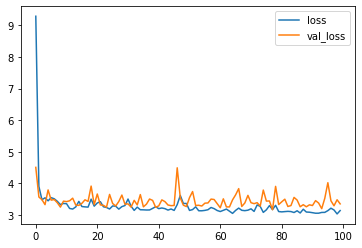

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

#### 6/ Evaluating the model:

To finish, we have to evaluate our model to see how much it is efficient to make the necessary predictions. For that, we will use the mean absolute error metric.

In [ ]:
predicted_yield = np.squeeze(model.predict(test_images))
true_yield = test_images.labels

In [ ]:
from sklearn.metrics import mean_absolute_error
err = mean_absolute_error(true_yield, predicted_yield)
print('The mean absolute error obtained while comparing the true yield and the predicted one is',err)

The mean absolute error obtained while comparing the true yield and the predicted one is 3.2790913910701356
